# Data preprocessing
Preprocess the raw time series measurents and create the test-train split to train the models.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import copy

## Read raw time series data
Read all CSVs and create two dataframes: real measurements and noise measurents
- Index: Time (relative)
- Column: Measurent (Voltage)

#### Real measurement data
Real mesurents are time series generated by the radiation source in the diode.

In [2]:
%%capture

# Create list with all CSV paths
paths_noise_csv = []
root_path = '../'

for folderName, subfolders, filenames in os.walk(root_path + 'data/raw/eventos'):
    for filename in filenames:
        paths_noise_csv.append(folderName + '/' + filename)

# Load data into dataframe
df_real = pd.DataFrame()
i = 0

for path in paths_noise_csv:
    df = pd.read_csv(path, skiprows=3, names=['time', 'voltage'])
    df.set_index('time', inplace=True)

    # Set index as time for the first CSV
    if i == 0:
        df_real.index = df.index

    # Store voltage reading as new column
    measurement_number = 'measurement_' + str(i)
    df_real[measurement_number] = df['voltage']

    i += 1

#### Noise measurement data
Noise measurements are the time series generated by the electrical noise in the diode.

In [3]:
%%capture

# Create list with all CSV paths
paths_noise_csv = []

for folderName, subfolders, filenames in os.walk(root_path + 'data/raw/ruido'):
    for filename in filenames:
        paths_noise_csv.append(folderName + '/' + filename)

# Load data into dataframe
df_noise = pd.DataFrame()
i = 0

for path in paths_noise_csv:
    df = pd.read_csv(path, skiprows=3, names=['time', 'voltage'])
    df.set_index('time', inplace=True)

    # Set index as time for the first CSV
    if i == 0:
        df_noise.index = df.index

    # Store voltage reading as new column
    measurement_number = 'measurement_' + str(i)
    df_noise[measurement_number] = df['voltage']

    i += 1

## Number of measurements
Total number of time series for each class.

In [4]:
print('Number of real measurements:', df_real.shape[1])
print('Number of noise measurements:', df_noise.shape[1])

Number of real measurements: 402
Number of noise measurements: 409


## Data cleaning
Actions to perform:
- Check how many measurements are duplicated.
- Delete duplicate mesurements.
- Delete incorrectly classified measurements.
- Delete NaN measurements

**Real data:**

In [5]:
# Check number of duplicate measurements
df_real_transposed = df_real.transpose()
print('Number of duplicated real measurements:',
      df_real_transposed.duplicated().sum())

# Delete duplicate measurements
df_real_transposed = df_real_transposed.drop_duplicates()
df_real = df_real_transposed.transpose().copy()

# Delete incorrectly classified measurements
incorrect_measurents = ['measurement_8',
                        'measurement_29',
                        'measurement_39',
                        'measurement_49',
                        'measurement_77',
                        'measurement_93',
                        'measurement_107',
                        'measurement_124',
                        'measurement_130',
                        'measurement_139',
                        'measurement_141',
                        'measurement_146',
                        'measurement_153',
                        'measurement_176',
                        'measurement_237',
                        'measurement_277',
                        'measurement_299',
                        'measurement_342',
                        'measurement_347',
                        'measurement_365',
                        ]
df_real.drop(incorrect_measurents, axis=1, inplace=True)
print('Number of incorrect measurements:', len(incorrect_measurents))


Number of duplicated real measurements: 1
Number of incorrect measurements: 20


**Noise data:**

In [6]:
# Check number of duplicate measurements
df_noise_transposed = df_noise.transpose()
print('Number of duplicated noise measurements:', df_noise_transposed.duplicated().sum())

# Delete duplicate measurements
df_noise_transposed = df_noise_transposed.drop_duplicates()
df_noise = df_noise_transposed.transpose().copy()

# Delete incorrectly classified measurements
incorrect_measurents = ['measurement_17',]
df_noise.drop(incorrect_measurents, axis=1, inplace=True)
print('Number of incorrect measurements:', len(incorrect_measurents))

Number of duplicated noise measurements: 81
Number of incorrect measurements: 1


## Real and noise time series comparison
Plot a sample of the real and noise time series for comparison.

In [7]:
# Function to create plot comparison
def plot_comparison(df1, df2, number_plots=5, title1='Real', title2='Noise'):
    fig, axes = plt.subplots(number_plots, 2, figsize=(15,2.5 * number_plots))

    # Set column titles
    axes[0,0].set_title(title1, fontsize=30)
    axes[0,1].set_title(title2, fontsize=30)

    # Plot left data
    i = 0
    for col in df1:
        sns.lineplot(data=df1, x='time', y=col, ax=axes[i,0])
        i += 1
        if i == number_plots:
            break

    # Plot right data
    i = 0
    for col in df2:
        sns.lineplot(data=df2, x='time', y=col, ax=axes[i,1])
        i += 1
        if i == number_plots:
            break

In [8]:
# Function to plot first N measurements from dataframe
def plot_number(df, number_plots=5, title='Title'):
    fig, axes = plt.subplots(number_plots, 1, figsize=(10,2.5 * number_plots))

    # Set column titles
    axes[0].set_title(title, fontsize=30)

    # Plot left data
    i = 0
    for col in df:
        sns.lineplot(data=df, x='time', y=col, ax=axes[i])
        i += 1
        if i == number_plots:
            break

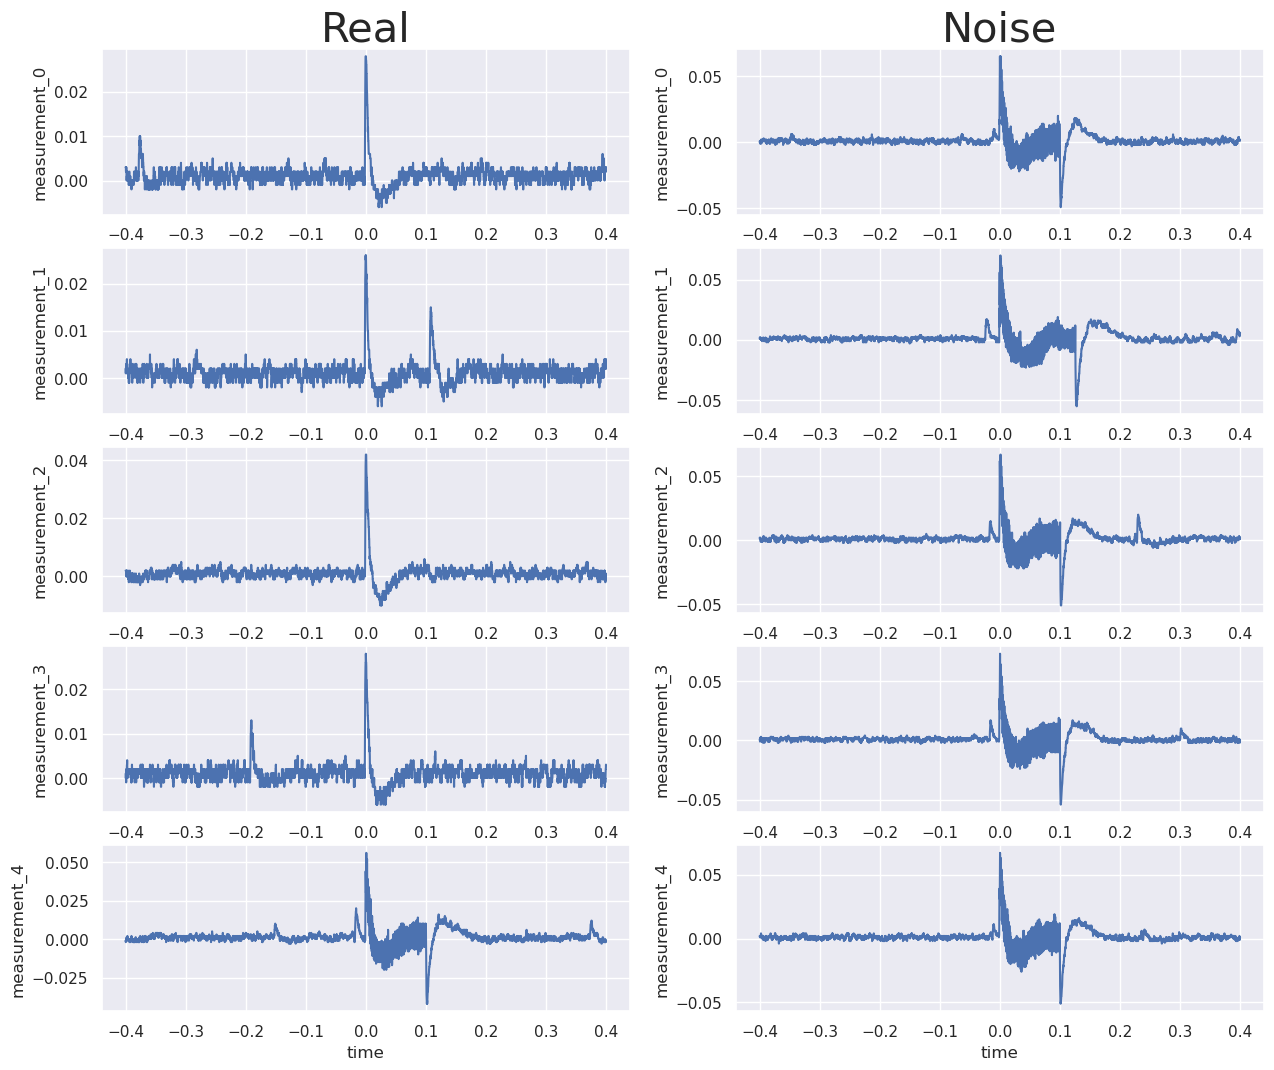

In [9]:
# Plot comparison
plot_comparison(df_real, df_noise, 5)

## Delete NaN measurements

In [10]:
# Delete NaN for real measurents
print('Number of real measurements with NaN values:', str(df_real.isna().sum()[df_real.isna().sum() > 0].count()))
df_real = df_real.dropna(axis=1)

# Delete NaN for noise measurents
print('Number of noise measurements with NaN values:', str(df_noise.isna().sum()[df_noise.isna().sum() > 0].count()))
df_noise = df_noise.dropna(axis=1)

Number of real measurements with NaN values: 0
Number of noise measurements with NaN values: 2


## Downsampling
Downsample data from 4000 samples to 400.

In [11]:
# Function to downsample the measurements by a factor of N using the MAX value
def downsample_max(df, factor=10):
    df = df.copy()  # Create copy to not affect original dataframe
    df['time'] = df.index   # Store index to not lose it
    df['timestamp'] = pd.date_range(
        start='2000', periods=df.shape[0], freq='S')
    df = df.resample(str(factor) + 'S', on='timestamp').max()
    df.index = df['time']
    df = df.drop(columns=['time'], axis=1)
    
    return df

Perform the downsampling and plot the results:

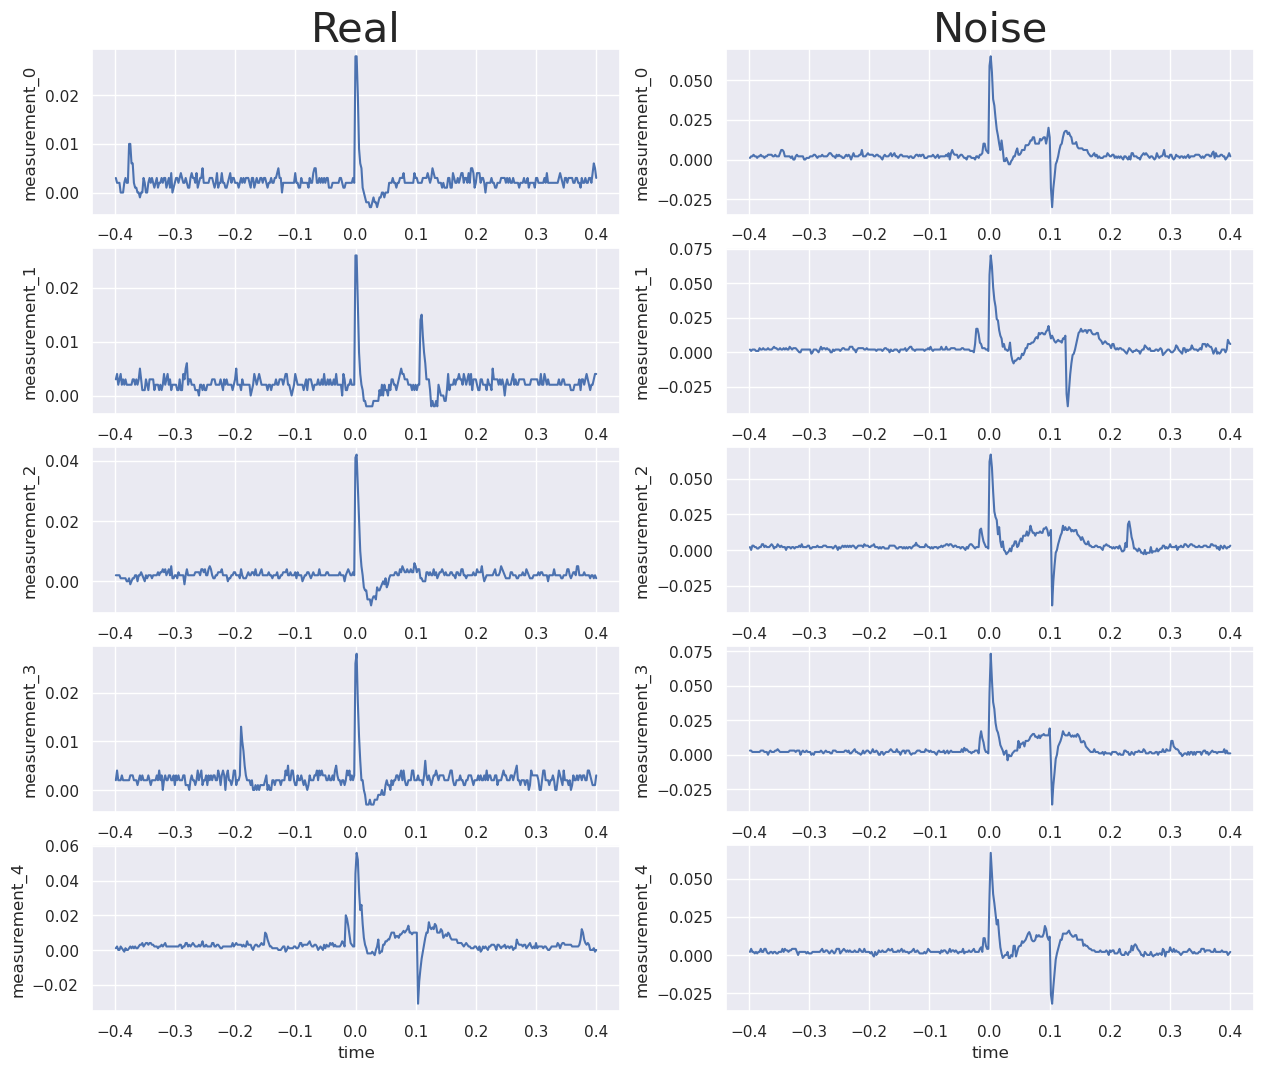

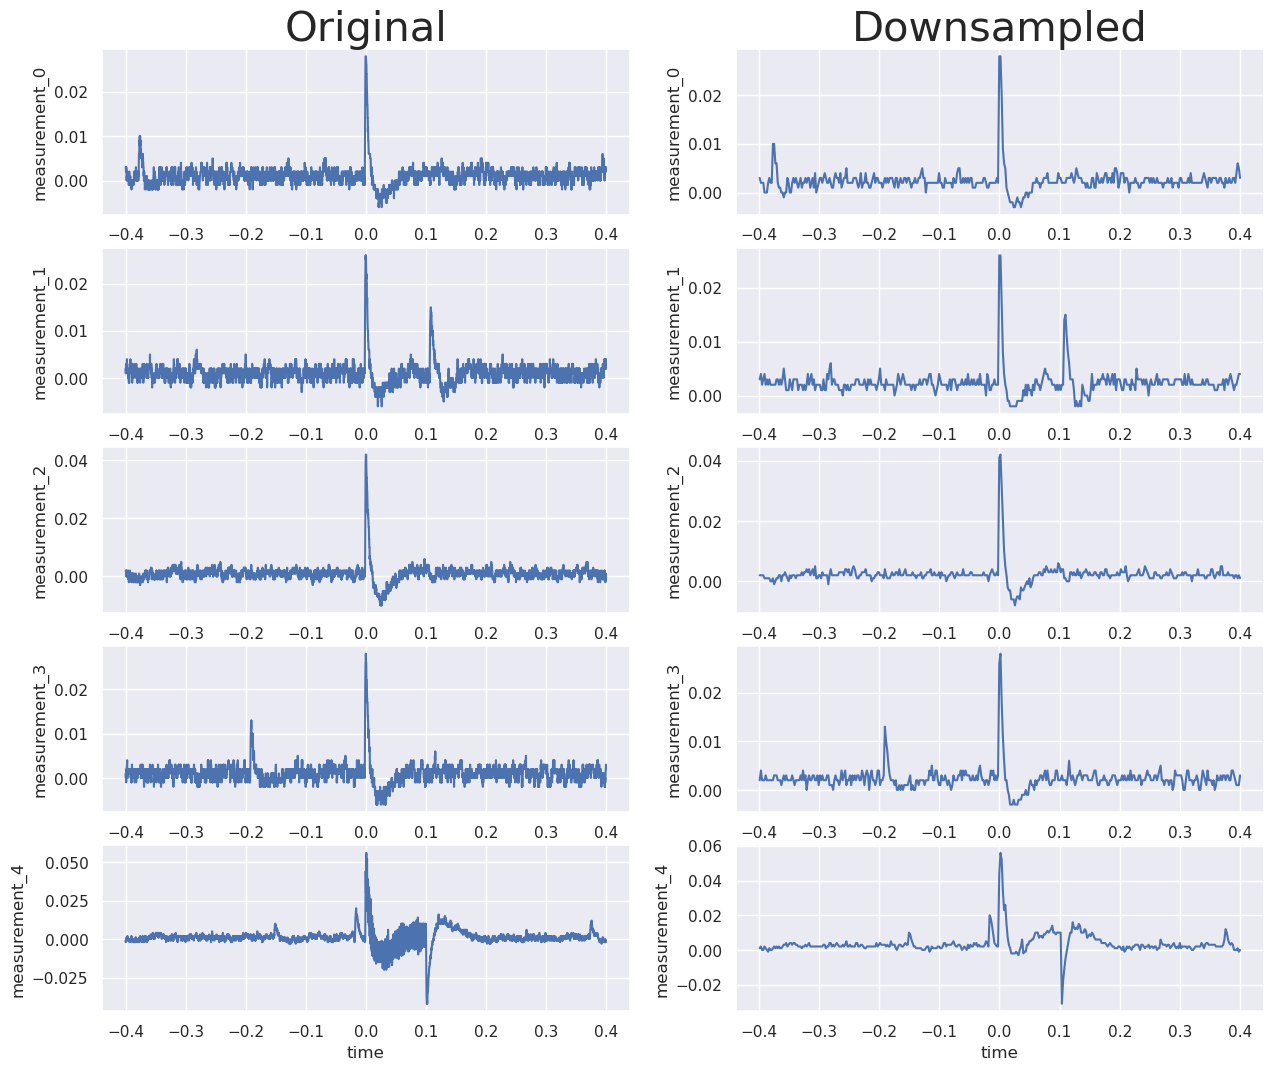

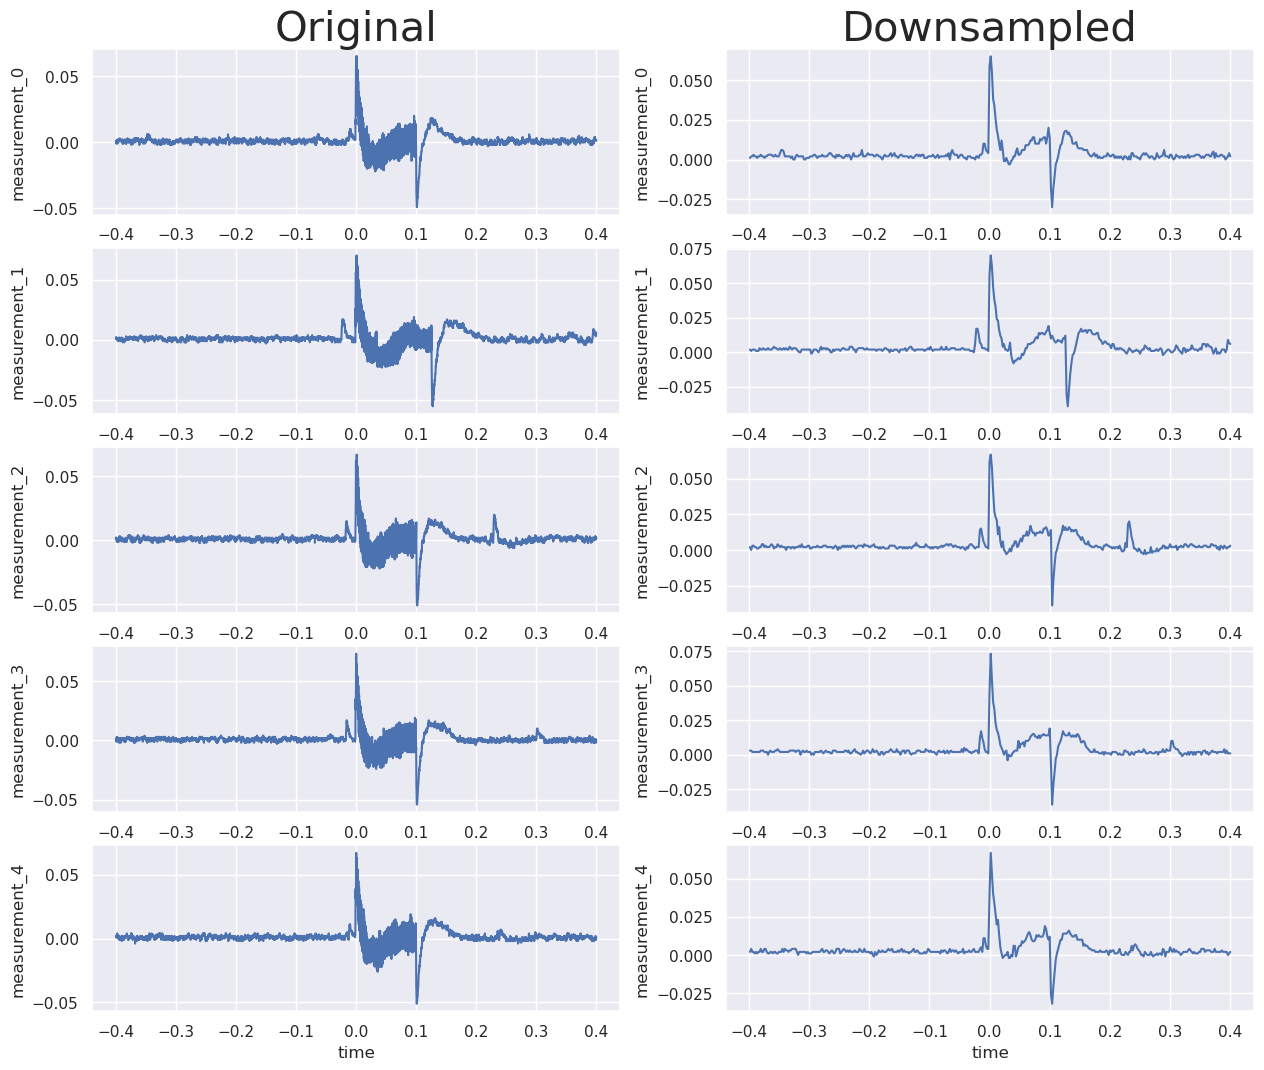

In [12]:
# Downsample measurents
df_real_downsampled = downsample_max(df_real, 10)
df_noise_downsampled = downsample_max(df_noise, 10)

# Plot results
plot_comparison(df_real_downsampled, df_noise_downsampled, 5)
plot_comparison(df_real, df_real_downsampled, 5, title1='Original', title2='Downsampled')
plot_comparison(df_noise, df_noise_downsampled, 5, title1='Original', title2='Downsampled')

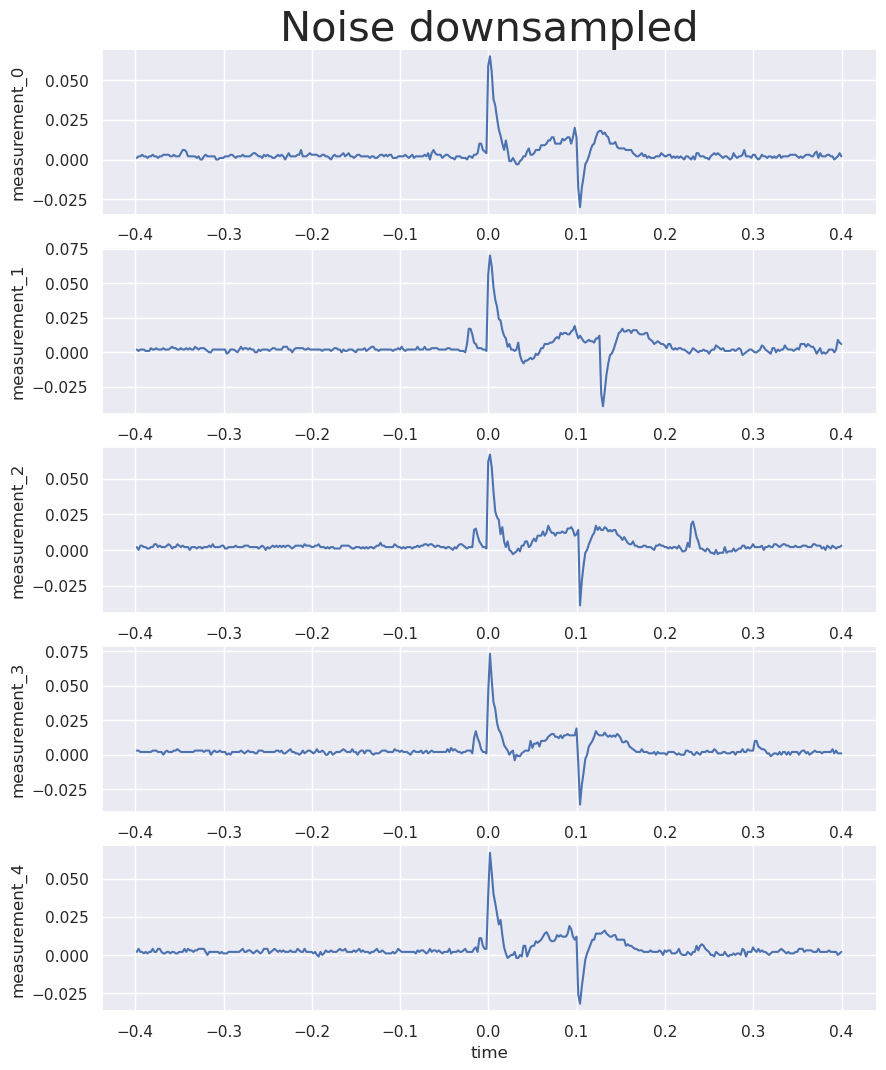

In [13]:
plot_number(df_noise_downsampled, 5, title='Noise downsampled')

## Trim time series
Keep only the information between -0.2 and 0.2 seconds to eliminate unnecessary information for training the algorithms.

In [14]:
# Only keep data between -0.2 and 0.2 seconds
df_real_downsampled = df_real_downsampled.loc[(-0.2 <= df_real_downsampled.index) & (df_real_downsampled.index <= 0.2)]
df_noise_downsampled = df_noise_downsampled.loc[(-0.2 <= df_noise_downsampled.index) & (df_noise_downsampled.index <= 0.2)]

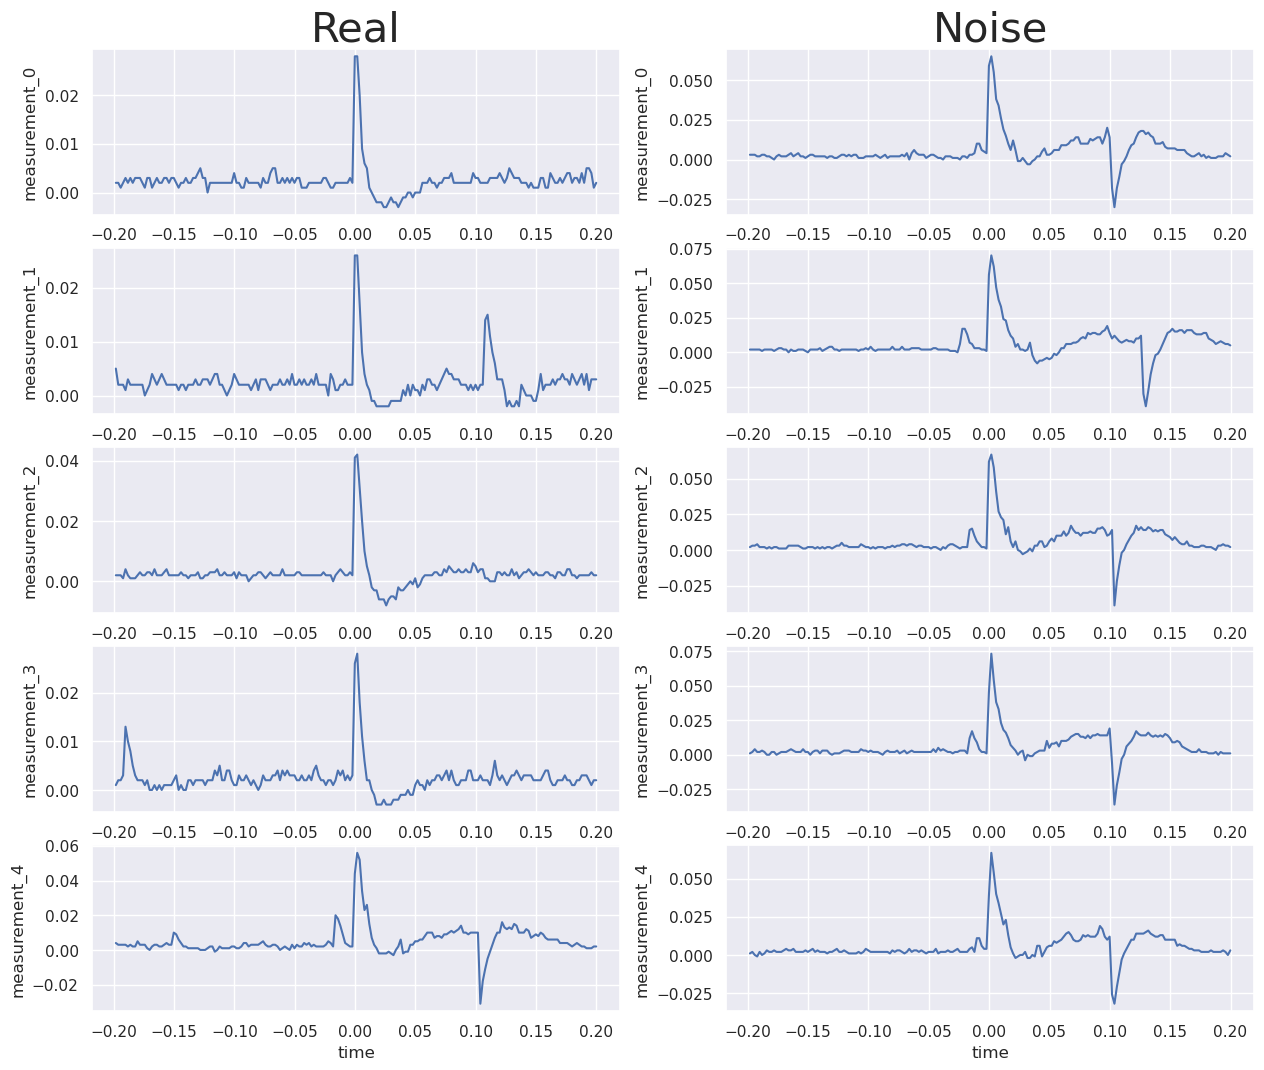

In [15]:
# Plot results
plot_comparison(df_real_downsampled, df_noise_downsampled)

## Create train and test data
- Change format:
    - Each time series will be a row.
    - First column will cointain label:
        - 1: Real data.
        - 0: Noise data.
- Combine noise and real measurements into a single dataframe.
- Shuffle the measurements.
- Divide 80% train - 20 % test split.
- Export as CSV.
    

In [16]:
from sklearn.model_selection import train_test_split

# Transpose each measurement as row
df_real_final = df_real_downsampled.transpose()
df_noise_final = df_noise_downsampled.transpose()

# Add labels
df_real_final.insert(loc=0, column='label', value=np.full(shape=df_real_final.shape[0], fill_value=1, dtype='int'))
df_noise_final.insert(loc=0, column='label', value=np.full(shape=df_noise_final.shape[0], fill_value=0, dtype='int'))

# Combine into single dataframe
df_final = pd.concat([df_real_final, df_noise_final])

# Shuffle the measurements
df_final = df_final.sample(frac=1, replace=False, random_state=42)

# Divide train-test split
X_train, X_test, y_train, y_test = train_test_split(df_final.loc[:, ~df_final.columns.isin(['label'])], df_final['label'], test_size=0.20, random_state=42)


In [19]:
# Export test and train data as CSV
X_train.to_csv(root_path + './data/processed/X_train.csv', index=False, header=False)
X_test.to_csv(root_path + './data/processed/X_test.csv', index=False, header=False)
y_train.to_csv(root_path + './data/processed/y_train.csv', index=False, header=False)
y_test.to_csv(root_path + './data/processed/y_test.csv', index=False, header=False)